# Final Project: Tesla

In [1]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
%matplotlib inline
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries

In [3]:
with open('alphavantage_api_key.txt') as file:
    alphavantage_api_key = file.read() 

In [4]:
ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')
df_tesla, meta_data = ts.get_daily_adjusted('TSLA', outputsize='full')

## Downloading historical data and cleaning up, leaving only "adjusted close" which we will rename as "close" price. During our most recent assignment, we were told to use adjusted close price as the more accurate measure of a stock's price. For this final project, I am making the same assumption and using adjusted close price of Tesla's stock.

In [5]:
df_tesla

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2021-10-19,877.5300,877.9500,862.5100,864.27,864.270,17381128.0,0.0,1.0
2021-10-18,851.7900,875.2600,851.4700,870.11,870.110,24207244.0,0.0,1.0
2021-10-15,823.7384,843.2100,822.3500,843.03,843.030,18924567.0,0.0,1.0
2021-10-14,815.4900,820.2500,813.3501,818.32,818.320,12247170.0,0.0,1.0
2021-10-13,810.4700,815.4100,805.7800,811.08,811.080,14120075.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2010-07-06,20.0000,20.0000,15.8300,16.11,3.222,6866900.0,0.0,1.0
2010-07-02,23.0000,23.1000,18.7100,19.20,3.840,5139800.0,0.0,1.0
2010-07-01,25.0000,25.9200,20.2700,21.96,4.392,8218800.0,0.0,1.0


In [6]:
df_tesla.drop(columns=['1. open','2. high','3. low','4. close', '6. volume', '7. dividend amount', '8. split coefficient'], inplace=True)

In [7]:
df_tesla.rename(columns={'5. adjusted close': 'close'}, inplace=True) 

In [8]:
df_tesla.sort_values('date', inplace=True)

<AxesSubplot:xlabel='date'>

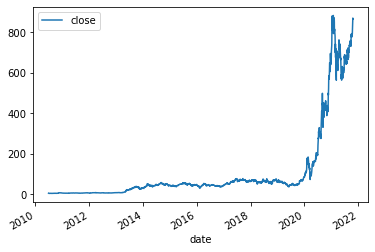

In [9]:
df_tesla.plot()

## Creating a 'pct_change' column to record daily percent change of Tesla's stock 

In [10]:
df_tesla['pct_change'] = df_tesla['close'].pct_change()

In [11]:
df_tesla

,close,pct_change
date,,
2010-06-29,4.778,NaN
2010-06-30,4.766,-0.002512
2010-07-01,4.392,-0.078473
2010-07-02,3.840,-0.125683
2010-07-06,3.222,-0.160937
...,...,...
2021-10-13,811.080,0.006652
2021-10-14,818.320,0.008926
2021-10-15,843.030,0.030196


## Creating an 'original_cumulative_return' column to record cumulative return if we had bought the stock on the first day and kept it untouched. This will serve as our benchmark once we get our own cumulative return

In [12]:
df_tesla['original_cumulative_return'] = (df_tesla['pct_change'] + 1).cumprod()

## Creating two other important benchmarks: short and long moving averages. The short will be a 30-day simple moving average while the long will be for 200 days. Comparing the closing price to one simple moving average carries high risk. To mitigate this risk, we want to create short and long moving averages to identify more conservative "buying" opportunities. 

In [13]:
df_tesla['short_moving_average']=df_tesla['close'].rolling(window=30).mean()

In [14]:
df_tesla['long_moving_average']=df_tesla['close'].rolling(window=200).mean()

## Creating a function to record daily percent change of our stock price when we decide to buy (take a "long" position). If the short moving average from the previous day is lower than the long moving average (also from the previous day), the stock is undervalued and we buy the stock the following day (reason for looking at moving averages for the prior day is that those moving averages are based on the close price, when we are unable to purchase the stock. Therefore, the earliest time we can buy the stock is at the beginning of next day). This is a more conservative method relative to that comparing a moving average directly to a closing price.

In [15]:
def daily_return(row):
    if (row-1)['short_moving_average'] < (row-1)['long_moving_average']:
        return (row)['pct_change']
    else:
        return 0

## We apply the above function to our dataframe so that we get a daily return whenever we take a long position. On days we don't take a long position, our daily return will be 0 as per the function defined above

In [16]:
df_tesla['daily_return']=df_tesla.apply(daily_return, axis=1)

## We calculate the cumulative return using all daily returns based on our long position using the equation provided on Canvas.

In [17]:
df_tesla['my_cumulative_return']=(df_tesla['daily_return']+1).cumprod()

## Our model yields a 3.89x return on our investment using two moving averages to determine long positions. This is lower than the original cumulative return of ~180x (if we bought the stock on day one and left it untouched), but is still an impressive result. This may be because we are taking a more conservative long position (only when short moving average < long moving average, rather than comparing either of them directly to closing price). There seems to be a trade-off between risks (more/less conservative) vs. returns (higher/lower teturns).

In [20]:
df_tesla

,close,pct_change,original_cumulative_return,short_moving_average,long_moving_average,daily_return,my_cumulative_return
date,,,,,,,
2010-06-29,4.778,NaN,NaN,NaN,NaN,0.0,1.000000
2010-06-30,4.766,-0.002512,0.997488,NaN,NaN,0.0,1.000000
2010-07-01,4.392,-0.078473,0.919213,NaN,NaN,0.0,1.000000
2010-07-02,3.840,-0.125683,0.803684,NaN,NaN,0.0,1.000000
2010-07-06,3.222,-0.160937,0.674341,NaN,NaN,0.0,1.000000
...,...,...,...,...,...,...,...
2021-10-13,811.080,0.006652,169.753035,764.697667,706.69080,0.0,3.888113
2021-10-14,818.320,0.008926,171.268313,767.505333,707.45245,0.0,3.888113
2021-10-15,843.030,0.030196,176.439933,771.193333,708.19370,0.0,3.888113


In [19]:
df_tesla.to_csv('final_project_asl2149.csv')